# Solve Differential Equations of the Lanchester Model with HHL

## Welcome to the Jungle of HHL - Rabbits vs. Foxes

The Lanchester model is widely used to describe the dynamics of combat between two opposing forces. Originally formulated for military applications, this model can also be adapted to other contexts, such as ecological competition between two species or market competition between two businesses. The model uses linear differential equations to capture the interactions between the populations, making it suitable for scenarios where interaction terms are purely linear. In this notebook, we explore solving this modified Lanchester model using the Harrow-Hassidim-Lloyd (HHL) algorithm, a quantum algorithm designed for efficiently solving linear systems of equations.

## Lanchester Model
[Lanchester Model](https://community.wolfram.com/groups/-/m/t/3055705) is described in this link. This differential equation describes the behavior of two forces, x and y:

$$
\frac{d x}{d t} = a*x + b*xy + c*y +d
$$
$$
\frac{d y}{d t} = e*y + f*xy + g*x +h
$$

where the coefficients described in the next sections indicate the sensitivities of each side to the other and to itself.

## Describing the Classical Model Using the [Finite Difference Method](https://en.wikipedia.org/wiki/Finite_difference_method)

Assuming b==0, f==0:

$$
x_{i+1}  = dt*a*x_i + dt*c*yi + dt*d + x_i = (dt*a+1)*x_i+ dt*c*y_i + dt*d
$$
$$
y_{i+1}  = dt*e*y_i + dt*g*xi + dt*h + y_i = (dt*e+1)*y_i + dt*g*x_i + dt*h
$$

The first sample is the initial condition:
$$
x_0 = X_0
$$
$$
y_0 = Y_0
$$

Then, for any next point, we solve numerically using the previous point:
$$
- (dt*a+1)*x_i - dt*c*y_i + x_{i+1}  = dt*d
$$
$$
- (dt*e+1)*y_i - dt*g*x_i + y_{i+1} = dt*h
$$



The system of linear equations describing the model looks like this:

<!--
$$
\begin{bmatrix}
    1           & 0         & 0         & \dots     & 0      & |& 0           & 0         & 0         & \dots     & 0 \\
    -(dt*a+1)   & 1         & 0         & \dots     & 0      & |& -dt*c       & 0         & 0         & \dots     & 0 \\
    0           & -(dt*a+1) & 1         & \dots     & 0      & |& 0           & -dt*c     & 0         & \dots     & 0 \\
                &           &           &           &        &\\
    0           & 0         & \dots     & -(dt*a+1) & 1      & |& 0           & 0         & \dots         & -dt*c     & 0 \\
    \hline
    0           & 0         & 0         & \dots     & 0 & |&1           & 0         & 0         & \dots     & 0\\
    -dt*g       & 0         & 0         & \dots     & 0 & |&-(dt*e+1)   & 1         & 0         & \dots     & 0\\
    0           & -dt*g     & 0         & \dots     & 0 & |&0           & -(dt*e+1)   & 1       & \dots     & 0\\
                &           &           &           &        &\\
    0           & 0         & \dots         & -dt*g     & 0 & |&0           & 0         & \dots     & -(dt*e+1) & 1\\
\end{bmatrix}
\times
\begin{bmatrix}
    x_{0} \\
    x_{1} \\
    x_{2} \\
    \vdots \\
    x_{N-1} \\
    y_{0} \\
    y_{1} \\
    y_{2} \\
    \vdots \\
    y_{N-1} \\
\end{bmatrix}
=
\begin{bmatrix}
    X_{0} \\
    dt*d \\
    dt*d \\
    \vdots \\
    dt*d \\
    Y_{0} \\
    dt*h \\
    dt*h \\
    \vdots \\
    dt*h \\
\end{bmatrix}
$$
-->

<div style="text-align:center;">
    <img src="https://docs.classiq.io/resources/hhl_jungle_matrix.png" alt="hhl_jungle_matrix.png"/>
</div>

## Building the Matrix with NumPy

In [1]:
import numpy as np


def diff_eq_model(a, b, c0, d, e, f, g, h, dt, N, x0, y0):
    assert b == 0, "model is currently unsupported"
    assert f == 0, "model is currently unsupported"

    A = np.identity(2 * N)

    for r in range(2 * N):
        if 1 <= r <= N - 1:
            c = r - 1
            A[r][c] = -(dt * a + 1)
            c = N + r - 1
            A[r][c] = -dt * c0
        elif N + 1 <= r:
            c = r - 1
            A[r][c] = -(dt * e + 1)
            c = r - 1 - N
            A[r][c] = -dt * g

    b1 = np.ones((N, 1)) * dt * d
    b1[0] = x0
    b2 = np.ones((N, 1)) * dt * h
    b2[0] = y0
    b = np.concatenate([b1, b2])

    return A, b

We choose specific values for the matrix, representing a predator-prey system. Here, \(x\) represents the prey population (e.g., rabbits), and \(y\) represents the predator population (e.g., foxes). The coefficients have the following meanings and specific values:

- \(a\) and \(e\) define the rate of natural losses or birth (due to death, disease, etc.). For example, \(a = -0.01\) (1% natural death rate for rabbits), \(e = -0.02\) (2% natural death rate for foxes).

- \(b\) and \(f\) define the rate of losses due to environmental factors (affecting both species). For example, \(b = 0\), \(f = 0\) (assuming no such environmental exposure for simplicity).

- \(c\) and \(g\) are losses or gains due to interactions between species (prey hunted by predators and vice versa). For example, \(c = -0.1\) (10% loss of rabbits due to predation), \(g = 0.2\) (20% increase in predator population due to hunting prey).

- \(d\) and \(h\) are gains due to migration. For example, \(d = 0.4\) (0.4 KRabbits/year migration rate for rabbits), \(h = 0.01\) (0.01 KFoxes/year migration rate for foxes).

In [2]:
N = 8  # N time steps
dt = 6  # Sample every dt years

A, b = diff_eq_model(
    a=-0.01, b=0, c0=-0.1, d=0.4, e=-0.02, f=0, g=0.02, h=0.01, dt=dt, N=N, x0=30, y0=1
)

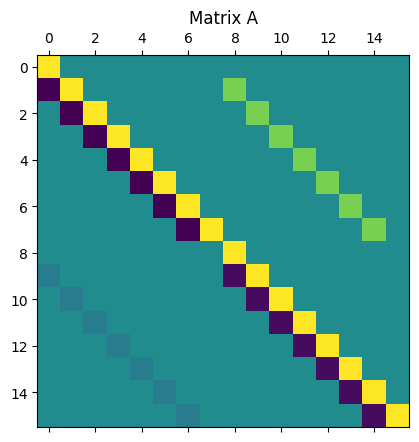

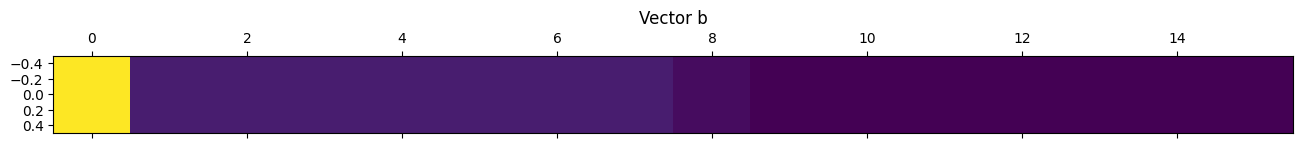

In [3]:
import matplotlib.pyplot as plt

plt.matshow(A)
plt.title("Matrix A")
plt.show()
plt.matshow(b.transpose())
plt.title("Vector b")
plt.show()

## Classical Solution

In [4]:
x = np.matmul(np.linalg.inv(A), b)

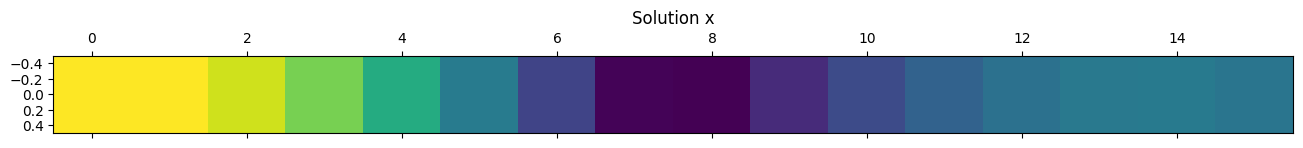

In [5]:
plt.matshow(x.transpose())
plt.title("Solution x")
plt.show()

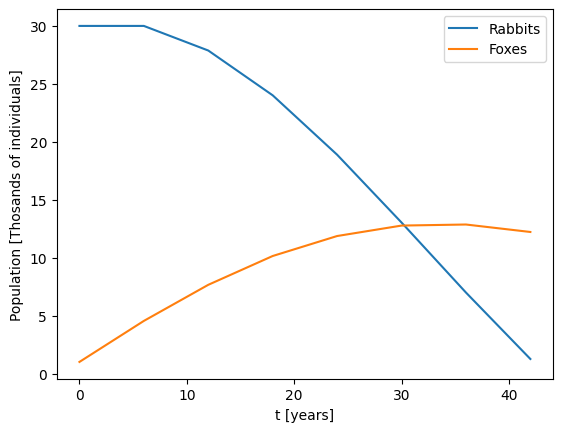

In [6]:
import matplotlib.pyplot as plt

t = dt * np.array(range(N))

x_sol = x[0:N]
y_sol = x[N : 2 * N]
plt.plot(t, x_sol, label="Rabbits")
plt.plot(t, y_sol, label="Foxes")
plt.xlabel("t [years]")
plt.ylabel("Population [Thosands of individuals]")
plt.legend()
plt.show()

Note that at some critical point, the rabbit population is so low that the fox population also starts to decrease. This is typical predator-prey model behavior.

## Redefining the Matrix
The matrix of HHL is a canonical one, assuming the following properties:

1. The RHS vector $\vec{b}$ is normalized.
2. The matrix $A$ is a Hermitian one.
3. The matrix $A$ is of size $2^n\times 2^n $.
4. The eigenvalues of $A$ are in the range $(0,1)$.

However, any general problem that does not follow these conditions can be resolved, as below.

### 1) Normalized b
As preprocessing, normalize $\vec{b}$ and then return the normalization factor as postprocessing.

In [7]:
norm_factor = np.linalg.norm(b)

b_normalized = b / norm_factor

### 2) Hermitian Matrix

Symmetrize the problem:
$$
\begin{pmatrix}
0 & A^T \\
A & 0
\end{pmatrix}
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
0  \\
\vec{b}
\end{pmatrix}.
$$
This increases the number of qubits by 1.

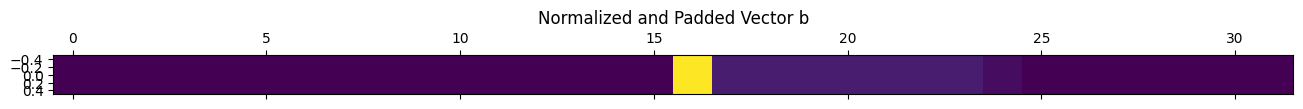

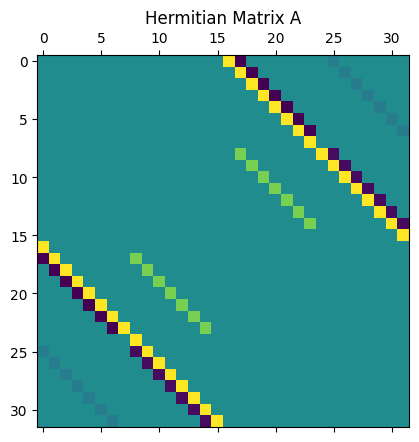

In [8]:
def to_hermitian(A):
    N = A.shape[0]
    A_hermitian = np.concatenate(
        [
            np.concatenate([np.zeros((N, N)), A.transpose().conj()], axis=1),
            np.concatenate([A, np.zeros((N, N))], axis=1),
        ]
    )
    return A_hermitian


b_new = np.concatenate([np.zeros((2 * N, 1)), b_normalized])
plt.matshow(b_new.transpose())
plt.title("Normalized and Padded Vector b")
plt.show()

A_hermitian = to_hermitian(A)
plt.matshow(A_hermitian)
plt.title("Hermitian Matrix A")
plt.show()

$$
A_{new} * [x, 0] = b_{new}
$$

### 3) Make the Matrix $A$ of Size $2^n\times 2^n $

Complete the matrix dimension to the closest $2^n$ with an identity matrix. The vector $\vec{b}$ is completed with zeros.
$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}.
$$

However, our matrix is already the right size.

### 4) Rescaled Matrix
If the eigenvalues of $A$ are in the range $[w_{\min},w_{\max}]$, we can employ transformations to the exponentiated matrix and then undo them to extract the results:
$$
\tilde{A}=(A-w_{\min}I)\left(1-\frac{1}{2^{m}}\right)\frac{1}{w_{\max}-w_{\min}}.
$$
The eigenvalues of this matrix lie in the interval $[0,1)$, and are related to the eigenvalues of the original matrix via
$$
\lambda = (w_{\max}+w_{\min})\tilde{\lambda}\left[1/\left(1-\frac{1}{2^{m}}\right)\right]+w_{\min},
$$
with $\tilde{\lambda}$ being an eigenvalue of $\tilde{A}$ resulting from the QPE algorithm. This relation between eigenvalues is then used for the expression inserted into the eigenvalue inversion, via the `AmplitudeLoading` function.

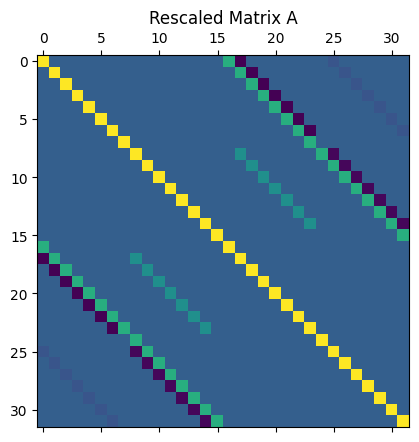

In [9]:
def condition_number(A):
    w, _ = np.linalg.eig(A)
    return max(np.abs(w)) / min(np.abs(w))


QPE_RESOLUTION_SIZE = 6

assert QPE_RESOLUTION_SIZE > np.log2(
    condition_number(A)
), "condition number is too big, and QPE resolution cannot hold all eigenvalues"

w, v = np.linalg.eig(A_hermitian)
w_max = np.max(w)
w_min = np.min(w)
mat_shift = -w_min
mat_rescaling = (1 - 1 / 2**QPE_RESOLUTION_SIZE) / (
    w_max - w_min
)  # assures eigenvalues in [0,1-1/2^QPE_SIZE]
min_possible_w = (
    w_max - w_min
) / 2**QPE_RESOLUTION_SIZE  # this is the minimal eigenvalue which can be resolved by the QPE

A_rescaled = (
    A_hermitian + mat_shift * np.identity(A_hermitian.shape[0])
) * mat_rescaling

# verifying that the matrix is symmetric and has eigenvalues in [0,1)
if not np.allclose(A_rescaled, A_rescaled.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")

w_rescaled, _ = np.linalg.eig(A_rescaled)

for lam in w_rescaled:
    if lam < -1e-6 or lam >= 1:
        raise Exception("Eigenvalues are not in (0,1)")

plt.matshow(A_rescaled)
plt.title("Rescaled Matrix A")
plt.show()

## Defining HHL Algorithm for the Quantum Solution
This section is based on Classiq HHL in the user guide, [here](https://github.com/Classiq/classiq-library/blob/main/tutorials/technology_demonstrations/hhl/hhl_example.ipynb) and [here](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb).

Note the rescaling in `simple_eig_inv` based on the matrix rescaling.

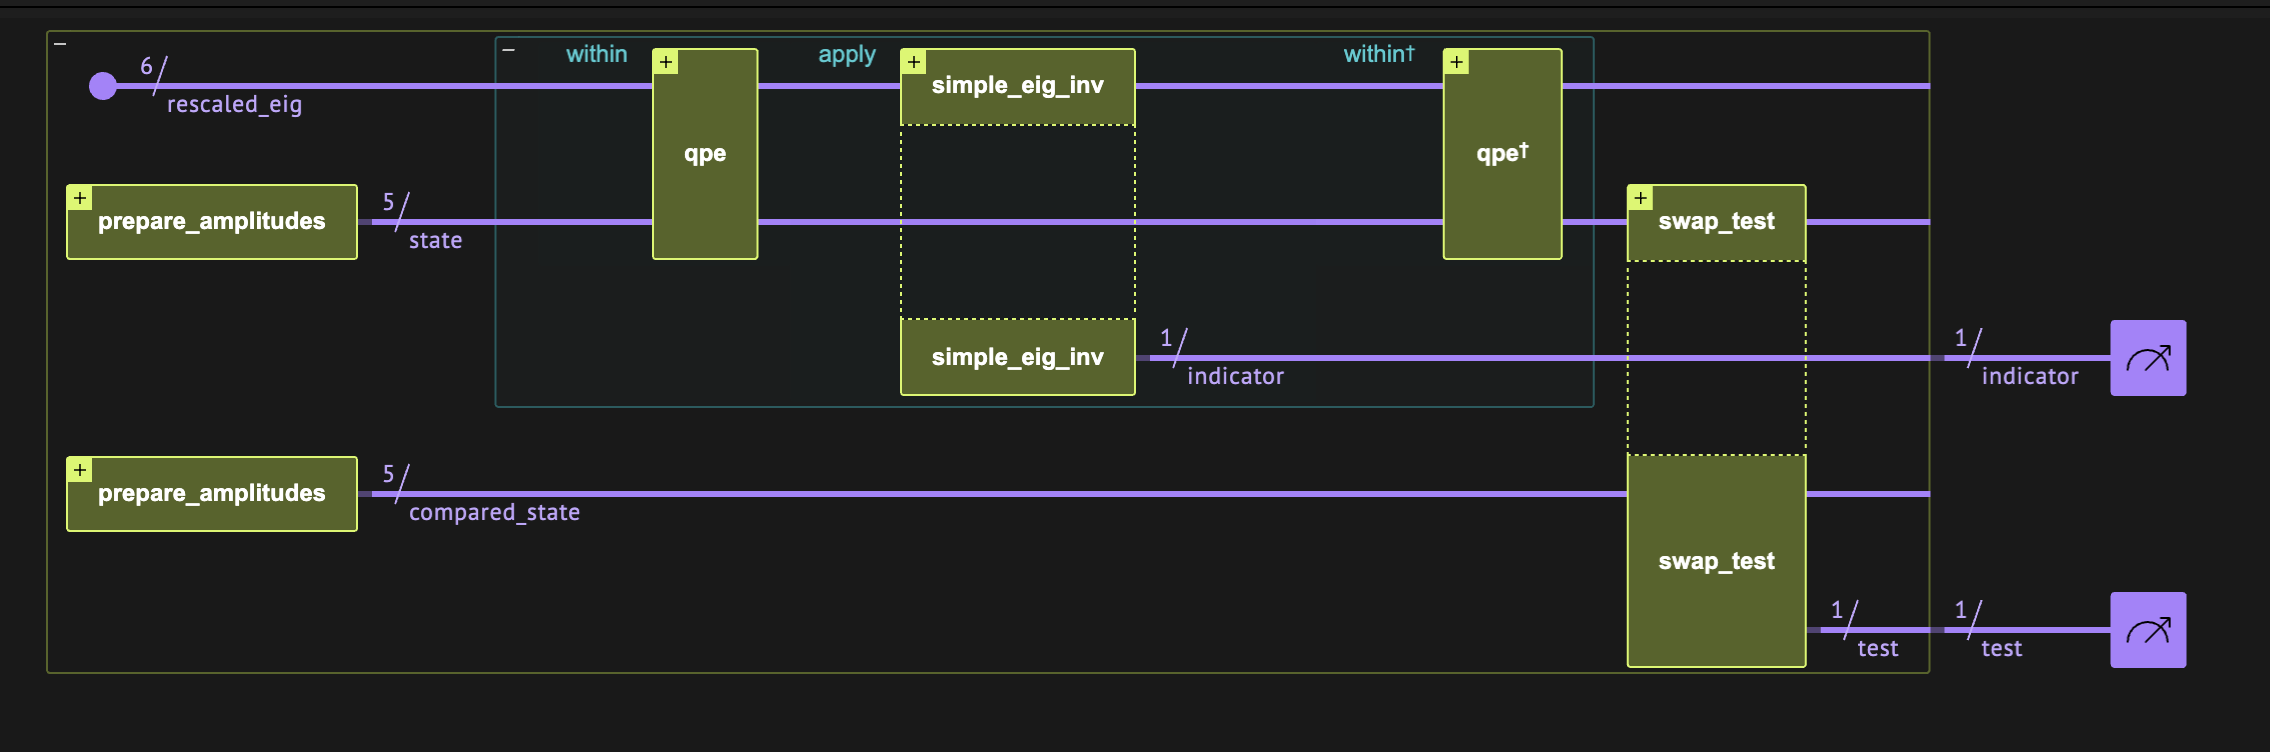

In [10]:
from classiq import *


@qfunc
def simple_eig_inv(
    gamma: CReal,
    delta: CReal,
    c_param: CReal,
    phase: QNum,
    indicator: Output[QBit],
):
    allocate(indicator)
    indicator *= c_param / ((gamma * phase) + delta)

In [11]:
sol_classical_hermitian = np.array([s[0] for s in np.linalg.solve(A_hermitian, b_new)])
compared_sol = sol_classical_hermitian * min_possible_w
amp_compared = compared_sol / np.linalg.norm(compared_sol)

Besides HHL, we also perform [swap test as in the user guide](https://github.com/Classiq/classiq-library/blob/main/algorithms/swap_test/swap_test.ipynb), comparing the HHL solution to a state preparation of the known solution.

In [12]:
import scipy

exponentiation_A_rescaled = scipy.linalg.expm(1j * 2 * np.pi * A_rescaled).tolist()
b_list = np.concatenate(b_new).tolist()
amp_compared_list = amp_compared.tolist()


@qfunc
def main(indicator: Output[QBit], test: Output[QBit]) -> None:
    state = QArray()
    compared_state = QArray()
    rescaled_eig = QNum()
    allocate(QPE_RESOLUTION_SIZE, UNSIGNED, QPE_RESOLUTION_SIZE, rescaled_eig)
    prepare_amplitudes(b_list, 0, state)
    within_apply(
        lambda: qpe(
            unitary=lambda: unitary(exponentiation_A_rescaled, state),
            phase=rescaled_eig,
        ),
        lambda: simple_eig_inv(
            gamma=mat_rescaling ** (-1),
            delta=-mat_shift,
            c_param=min_possible_w,
            phase=rescaled_eig,
            indicator=indicator,
        ),
    )
    prepare_amplitudes(amp_compared_list, 0.0, compared_state)
    swap_test(state, compared_state, test)

We create the circuit with depth limitation compared to the maximal width in a simulator (25).
We also set the preferences for synthesis and execution.

In [13]:
MAX_WIDTH_SWAP_TEST = 25
constraints = Constraints(
    max_width=MAX_WIDTH_SWAP_TEST,
    # optimization_parameter=OptimizationParameter.DEPTH,
)
preferences = Preferences(
    optimization_level=0, optimization_timeout_seconds=90, transpilation_option="none"
)
NUM_SHOTS = 30000
execution_preferences = ExecutionPreferences(num_shots=NUM_SHOTS)

qmod_hhl_swap_test = create_model(main, constraints, execution_preferences, preferences)

### Synthesize and Show

In [14]:
qprog_hhl_swap = synthesize(qmod_hhl_swap_test)
show(qprog_hhl_swap)

Quantum program link: https://platform.classiq.io/circuit/32pYMP0SkTE1XlWt7bZtuEIy0Wk


### Execution and Results Analysis
The analysis is explained in the [swap test user guide](https://github.com/Classiq/classiq-library/blob/main/algorithms/swap_test/swap_test.ipynb).

We compare the measured overlap with the exact overlap using the expected probability of measuring the state $|0\rangle$, defined as
$$
\alpha^2 = \frac{1}{2}\left(1+|\langle \psi_1 |\psi_2 \rangle |^2\right).
$$
We extract the overlap $|\langle \psi_1 |\psi_2 \rangle |^2=\sqrt{2 P\left(q_{\text{test}}=|0\rangle\right)-1}$.
The exact overlap is computed with the dot product of the two state vectors.
Note that for the sake of this demonstration we execute this circuit $100,000$ times to improve the precision of the probability estimate. This is usually not required.

Since we are in the HHL context, we filter only the `indicator==1` results.


In [26]:
execution_job_id = execute(qprog_hhl_swap)

In [27]:
result = execution_job_id.result_value()
fidelity_basic = np.sqrt(
    result.counts_of_multiple_outputs(["indicator", "test"])[("1", "0")]
    * 2
    / (result.counts_of_output("indicator")["1"])
    - 1
)

print("Fidelity between basic HHL and classical solutions:", fidelity_basic)

Fidelity between basic HHL and classical solutions: 0.9588607403653148


In the IDE we can also check that among the `indicator=1` results, the bar of `test=0` is much higher than `test=1`.

In [17]:
execution_job_id.open_in_ide()

## State Vector Simulation
We can also run the state vector of the HHL result and examine it without a swap test. Extracting the full information is exponentially hard, and used here just for educational purposes.
Extension of this work can extract some information from the state vector, such as the last element, which is the most important. We can also pad the last solution with an extension, and therefore measure the last point with high probability.

In [18]:
class TimeIndexAndGroup(QStruct):
    rabbits: QBit
    time_index: QNum


@qfunc
def main(
    indicator: Output[QBit],
    time_index_and_group: Output[TimeIndexAndGroup],
    rescaled_eig: Output[QNum],
) -> None:
    allocate(QPE_RESOLUTION_SIZE, False, QPE_RESOLUTION_SIZE, rescaled_eig)
    prepare_amplitudes(b_list, 0, time_index_and_group)
    within_apply(
        lambda: qpe(
            unitary=lambda: unitary(exponentiation_A_rescaled, time_index_and_group),
            phase=rescaled_eig,
        ),
        lambda: simple_eig_inv(
            gamma=mat_rescaling ** (-1),
            delta=-mat_shift,
            c_param=min_possible_w,
            phase=rescaled_eig,
            indicator=indicator,
        ),
    )


MAX_WIDTH_BASIC = 18
constraints = Constraints(max_width=MAX_WIDTH_BASIC)
preferences = Preferences(
    optimization_level=0, optimization_timeout_seconds=90, transpilation_option="none"
)
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
execution_preferences = ExecutionPreferences(
    num_shots=1, backend_preferences=backend_preferences
)

qmod_hhl_basic = create_model(
    main,
    constraints=constraints,
    preferences=preferences,
    execution_preferences=execution_preferences,
)
write_qmod(qmod_hhl_basic, "hhl_lanchester", decimal_precision=12)
qprog_hhl_basic = synthesize(qmod_hhl_basic)
show(qprog_hhl_basic)

Quantum program link: https://platform.classiq.io/circuit/32pYeoV9XByZSLBNbHu9v2kTpvm


In [19]:
execution_job_id = execute(qprog_hhl_basic)
result = execution_job_id.result_value()
# statevector = result.state_vector
execution_job_id.open_in_ide()

We filter the results, then extract the amplitudes of the state vector and compare them to the classical solution. We filter only the `indicator=1` and `phase=0` results.

In [20]:
filtered_hhl_statevector = dict()
for sample in result.parsed_state_vector:
    if sample.state["indicator"] == 1 and sample.state["rescaled_eig"] == 0:
        filtered_hhl_statevector[sample.state["time_index_and_group"]] = (
            sample.amplitude
        )

states = sorted(filtered_hhl_statevector)
raw_qsol = np.array([filtered_hhl_statevector[s] for s in states])

Let's compare the raw solution to the Hermitian matrix with the classical one.

/home/dor/Sources/Classiq/library-venv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/dor/Sources/Classiq/library-venv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


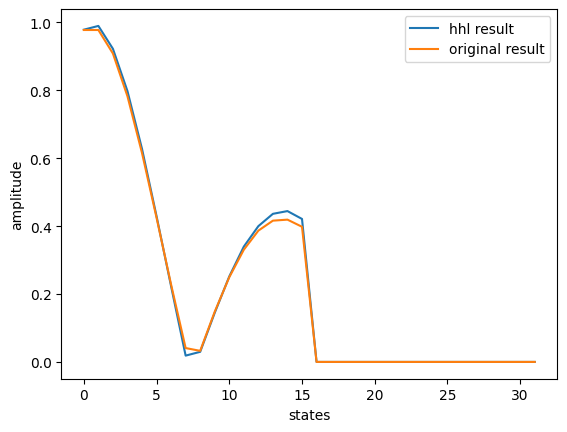

In [21]:
qsol_hermitian = raw_qsol / (min_possible_w)

plt.plot(np.real(states), qsol_hermitian)
plt.plot(np.real(states), sol_classical_hermitian)
plt.xlabel("states")
plt.ylabel("amplitude")
plt.legend(["hhl result", "original result"])
plt.show()

Now we can compare the two solutions in the time domain, after putting back the normalization factor.

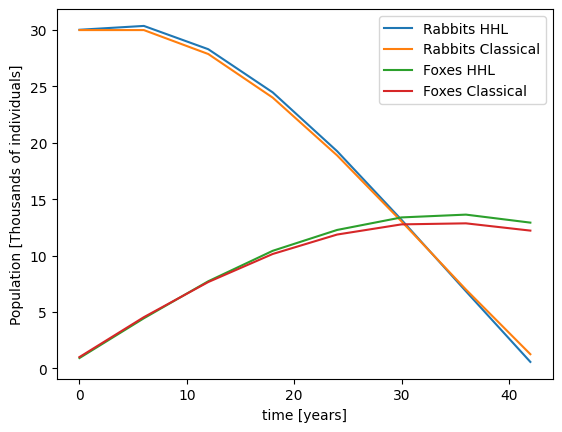

In [22]:
plt.plot(t, norm_factor * qsol_hermitian[0:N], label="Rabbits HHL")
plt.plot(t, norm_factor * sol_classical_hermitian[0:N], label="Rabbits Classical")

plt.plot(t, norm_factor * qsol_hermitian[N : 2 * N], label="Foxes HHL")
plt.plot(t, norm_factor * sol_classical_hermitian[N : 2 * N], label="Foxes Classical")
plt.xlabel("time [years]")
plt.ylabel("Population [Thousands of individuals]")
plt.legend()
plt.show()

The fidelity of the state vector solution can be calculated as the overlap of the two solutions.

In [23]:
fidelity = (
    np.abs(
        np.dot(
            sol_classical_hermitian / np.linalg.norm(sol_classical_hermitian),
            qsol_hermitian / np.linalg.norm(qsol_hermitian),
        )
    )
    ** 2
)
print("Statevector Solution Fidelity:", fidelity)

Statevector Solution Fidelity: 0.999646266787624
